# 量子ダイナミクスシミュレーション

第二回の後半は、量子コンピュータの並列性を利用した計算の代表例として、量子系のダイナミクスシミュレーションについて学びます。

```{contents} 目次
---
local: true
---
```

$\newcommand{ket}[1]{|#1\rangle}$
$\newcommand{\upket}{\ket{\!\uparrow}}$
$\newcommand{\downket}{\ket{\!\downarrow}}$
$\newcommand{\rightket}{\ket{\!\rightarrow}}$
$\newcommand{\leftket}{\ket{\!\leftarrow}}$

## 量子系のダイナミクスとは

量子力学について少しでも聞いたことのある方は、量子力学の根幹にシュレーディンガー方程式というものが存在することを知っているかと思います。この方程式は

$$
i \hbar \frac{\partial}{\partial t} \ket{\psi (t)} = H \ket{\psi (t)}
$$

などと表現され、時刻$t$のある系の状態$\ket{\psi (t)}$の時間微分（左辺）が$\ket{\psi (t)}$へのハミルトニアンという演算子の作用で定まる（右辺）ということを表しています。ただしこの「微分形」の方程式は我々の目的には少し使いづらいので、ここでは等価な「積分形」にして

$$
\ket{\psi (t_1)} = \exp \left( -\frac{i}{\hbar} \int_{t_0}^{t_1} H dt \right) \ket{\psi (t_0)}
$$

と書いておきます。特に、ハミルトニアン$H$が直接時間に依存しない場合は

$$
\ket{\psi (t_1)} = \exp \left( -\frac{i}{\hbar} (t_1 - t_0) H \right) \ket{\psi (t_0)}
$$

です。以下このケースのみを考えます。量子状態に対する演算子（線形演算子）の指数関数もまた演算子なので、積分形のシュレーディンガー方程式は「$e^{-i/\hbar (t_1-t_0) H}$という演算子が系を時刻$t_0$の初期状態$\ket{\psi(t_0)}$から時刻$t_1$の状態$\ket{\psi(t_1)}$に発展させる」と読めます。さらに、定義上ハミルトニアンは「エルミート演算子」であり、それに虚数単位をかけて指数の冪にした$e^{-i/\hbar t H}$（以下これを時間発展演算子$U_H(t)$と呼びます）は「ユニタリ演算子」です（このあたりの線形代数の用語にあまり馴染みがなくても、そういうものかと思ってもらえれば結構です）。

ユニタリ演算子は量子計算の言葉で言えばゲートにあたります。したがって、ある量子系に関して、その初期状態を量子レジスタで表現でき、時間発展演算子を量子コンピュータの基本ゲートの組み合わせで実装できれば、その系のダイナミクス（＝時間発展）シミュレーションを量子コンピュータで行うことができます。

### 例：核磁気の歳差運動

シミュレーションの詳しい話をする前に、これまで量子力学と疎遠だった方のために、ハミルトニアンや時間発展とは具体的にどういうことか、簡単な例を使って説明します。

空間中に固定されたスピン$\frac{1}{2}$原子核一つを考えます。ある方向（Z方向とします）のスピン$\pm \frac{1}{2}$の状態をそれぞれ$\upket, \downket$で表します。量子力学に馴染みのない方のための説明例で大いに量子力学的な概念を使っていますが、何の話かわからなければ「2つの基底ケットで表現される、量子ビットのような物理系がある」と考えてください。量子ビットのような物理系なので、系の状態は一般に$\upket$と$\downket$の重ね合わせになります。

時刻$t_0$で系が$\ket{\psi(t_0)} = \upket$にあるとします。時刻$t_1$での系の状態を求めることは

$$
\ket{\psi (t_1)} = \alpha (t_1) \upket + \beta (t_1) \downket
$$

の$\alpha (t_1)$と$\beta (t_1)$を求めることに相当します。ここで$\alpha (t_0) = 1, \beta (t_0) = 0$です。

この原子核に$X$方向の一定磁場をかけます。非ゼロのスピンを持つ粒子はスピンベクトル$\vec{\sigma}$と平行な磁気モーメント$\vec{\mu}$を持ち、磁場$\vec{B}$のもとでエネルギー$-\vec{B}\cdot\vec{\mu}$を得ます。ハミルトニアンとは実は系のエネルギーを表す演算子なので、この一定磁場だけに注目した場合の系のハミルトニアンは、何かしらの定数$\omega$とスピンベクトルの$X$成分$\sigma^X$を用いて$H = \hbar \omega \sigma^X$と書けます。

量子力学では$\sigma^X$は演算子であり、$\upket$と$\downket$に対して

$$
\sigma^X \upket = \downket \\
\sigma^X \downket = \upket
$$

と作用します。時間発展演算子$U_H(t)$は

$$
U_H(t) = \exp (-i \omega t \sigma^X) = \sum_{n=0}^{\infty} \frac{1}{n!} (-i \omega t)^n (\sigma^X)^n = I + (-i \omega t) \sigma^X + \frac{1}{2} (-i \omega t)^2 (\sigma^X)^2 + \frac{1}{6} (-i \omega t)^3 (\sigma^X)^3 \cdots
$$

ですが（$I$は恒等演算子）、上の$\sigma^X$の定義からわかるように$(\sigma^X)^2 = I$なので

```{math}
:label: exp_sigmax
\begin{align}
\exp (-i \omega t \sigma^X) & = \left[ 1 + \frac{1}{2} (-i \omega t)^2 + \cdots \right] I + \left[(-i \omega t) + \frac{1}{6} (-i \omega t)^3 + \cdots \right] \sigma^X \\
& = \cos(\omega t) I - i \sin(\omega t) \sigma^X
\end{align}
```

と書けます。したがって、

```{math}
:label: spin_exact
\ket{\psi (t_1)} = U_H(t_1 - t_0) \ket{\psi (t_0)} = \exp [-i \omega (t_1 - t_0) \sigma^X] \upket = \cos[\omega (t_1 - t_0)] \upket - i \sin[\omega (t_1 - t_0)] \downket
```

です。任意の時刻$t_1$のスピンの状態が基底$\upket$と$\downket$の重ね合わせとして表現されました。

このように、系のエネルギーの表式からハミルトニアンが決まり、その指数関数を初期状態に作用させることで時間発展後の系の状態が求まります。

ちなみに、$\ket{\psi (t_1)}$は$t_1 = t_0$で$\upket$、$t_1 = t_0 + \pi / (2 \omega)$で$(-i)\downket$となり、以降$\upket$と$\downket$を周期的に繰り返します。実は、その間の状態はスピンが$Y$-$Z$平面内を向いている状態に相当します。スピンが0でない原子核に磁場をかけると、スピンと磁場の方向が揃っていなければ磁場の方向を軸にスピンが歳差運動（すりこぎ運動）をします。これはコマが重力中で起こす運動と同じで、核磁気共鳴（NMR、さらに医学応用のMRI）の原理に深く関わります。

### 量子コンピュータ上での表現

すでに触れましたが、上の例で核のスピンは量子ビットのように2つの基底ケットを持ちます（2次元量子系です）。さらに、お気づきの方も多いと思いますが、$\sigma^X$の$\upket$と$\downket$への作用は$X$ゲートの$\ket{0}$と$\ket{1}$への作用そのものです。このことから、核磁気の歳差運動が極めて自然に量子コンピュータでシミュレートできることがわかるかと思います。

実際には、時間発展演算子は$\sigma^X$そのものではなくその指数関数なので、量子コンピュータでも$\exp (-i \theta/2 X)$に対応する$R_{x} (\theta)$ゲートを利用します。これまで紹介されませんでしたが、$R_{x}$ゲートはパラメータ$\theta$をとり、

$$
R_{x}(\theta)\ket{0} = \cos\frac{\theta}{2}\ket{0} - i\sin\frac{\theta}{2}\ket{1} \\
R_{x}(\theta)\ket{1} = -i\sin\frac{\theta}{2}\ket{0} + \cos\frac{\theta}{2}\ket{1}
$$

という変換を行います。上の核スピン系を量子コンピュータでシミュレートするには、1量子ビットで$R_{x} (2 \omega (t_1 - t_0)) \ket{0}$を計算する以下の回路を書けばいいだけです。

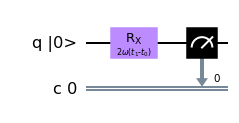

In [1]:
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.circuit import Parameter
import numpy as np

circuit = QuantumCircuit(QuantumRegister(1, 'q'), ClassicalRegister(1, 'c'))
circuit.rx(Parameter(r'$2 \omega (t_1 - t_0)$'), 0)
circuit.measure(0, 0)
circuit.draw('mpl', initial_state=True)

### ハミルトニアンの対角化

再び量子コンピュータを離れて、量子・古典に関わらずデジタル計算機で量子ダイナミクスのシミュレーションをする際の一般論をします。

上の核スピンの例ではハミルトニアンが単純だったので、式{eq}`spin_exact`のように厳密解が求まりました。特に、導出において$(\sigma^X)^2 = I$という恒等式が非常に重要でした。しかし、一般のハミルトニアンでは、何乗しても恒等演算子の定数倍にたどり着く保証がありません。

累乗して恒等演算子にならないようなハミルトニアンであっても、系の次元が小さい場合は「対角化」という作業で厳密解を得られます。ハミルトニアンの対角化とは、ハミルトニアンの作用が実数をかけることと等しくなるようなケットを探してくること、つまり

$$
H\ket{\phi_j} = \hbar \omega_j \ket{\phi_j}, \quad \omega_j \in \mathbb{R}
$$

が成り立つような$\ket{\phi_j}$を見つけることを指します。このような$\ket{\phi_j}$を「固有値$\hbar \omega_j$を持つ$H$の固有ベクトル」と呼びます。「エネルギー固有状態」と呼ぶこともあります。系の次元が$N$であれば、独立な固有ベクトルが$N$個存在します。

例えば上の例では$H = \hbar \omega \sigma^X$ですが、

```{math}
:label: left_right_kets
\rightket := \frac{1}{\sqrt{2}}(\upket + \downket) \\
\leftket := \frac{1}{\sqrt{2}}(\upket - \downket)
```

という2つの状態を考えると

$$
\sigma^X \rightket = \rightket \\
\sigma^X \leftket = -\leftket
$$

なので、これらが固有値$\pm \hbar \omega$の$H$の固有ベクトルとなっていることがわかります。

固有値$\hbar \omega_j$のハミルトニアン$H$の固有ベクトル$\ket{\phi_j}$は自動的に時間発展演算子$U_H(t)$の固有値$e^{-i\omega_j t}$の固有ベクトルでもあります。

$$
U_H(t) \ket{\phi_j} = \exp \left( -\frac{i}{\hbar} t H \right) \ket{\phi_j} = \exp (-i \omega_j t) \ket{\phi_j}.
$$

したがって、系の初期状態$\ket{\psi (t_0)}$が

$$
\ket{\psi (t_0)} = \sum_{j=0}^{N} c_j \ket{\phi_j}
$$

であれば、時刻$t_1$での状態は

$$
\ket{\psi (t_1)} = \sum_{j=0}^{N} c_j U_H(t_1 - t_0) \ket{\phi_j} = \sum_{j=0}^{N} e^{-i \omega_j (t_1 - t_0)} c_j \ket{\phi_j},
$$

つまり、各固有ベクトルの振幅に、対応する位相因子をかけるだけで求まります。

再び核スピンの例を見ると、初期状態$\ket{\psi(t_0)} = \upket = 1/\sqrt{2} (\rightket + \leftket)$なので、

$$
\begin{align}
\ket{\psi(t_1)} & = \frac{1}{\sqrt{2}} \left( e^{-i\omega (t_1 - t_0)} \rightket + e^{i\omega (t_1 - t_0)} \leftket \right) \\
& = \frac{1}{2} \left[ \left( e^{-i\omega (t_1 - t_0)} + e^{i\omega (t_1 - t_0)} \right) \upket + \left( e^{-i\omega (t_1 - t_0)} - e^{i\omega (t_1 - t_0)} \right) \downket \right] \\
& = \cos [\omega (t_1-t_0)] \upket - i \sin [\omega (t_1-t_0)] \downket
\end{align}
$$

となり、式{eq}`spin_exact`が再導出できます。

このように、ハミルトニアンの対角化さえできれば、量子ダイナミクスのシミュレーションは位相をかけて足し算をするだけの問題に帰着します。しかし、上で言及したように、計算量の問題から、ハミルトニアンが対角化できるのは主に系の次元が小さいときに限ります。「対角化」という言葉が示唆するように、この操作は行列演算（対角化）を伴い、その際の行列の大きさは$N \times N$です。上の核スピンの例では$N=2$でしたが、もっと実用的なシミュレーションの場合、系の量子力学的次元は一般的に関係する自由度の数（粒子数など）の指数関数的に増加します。比較的小規模な系でもすぐに対角化にスーパーコンピュータが必要なスケールになってしまいます。

### 鈴木・トロッター分解

ハミルトニアンが対角化できない場合、ダイナミクスシミュレーションをするには、結局式{eq}`spin_exact`のように初期状態に時間発展演算子を愚直にかけていくことになります。これは、式{eq}`exp_sigmax`のように$U_H(t)$を閉じた形式で厳密に書けるなら簡単な問題ですが、そうでない場合は数値的に近似していく必要があります。その場合の常套手段は、行いたい時間発展$(t_1 - t_0)$を短い時間

$$
\Delta t = \frac{t_1 - t_0}{M}, \quad M \gg 1
$$

に分割し、$\Delta t$だけの時間発展$U_H(\Delta t)$を近似する演算子$\tilde{U}_{H;\Delta t}$を考えることです。この$\tilde{U}_{H;\Delta t}$での状態の遷移の様子がわかるのであれば、それを$M$回繰り返すことで、求める終状態が近似できます。

通常$H$はわかっており、任意の状態$\ket{\psi}$に対して$H\ket{\psi}$が計算できるので、例えば$\mathcal{O}((\Delta t)^2)$を無視する近似で

$$
\tilde{U}_{H;\Delta t} = I - \frac{i \Delta t}{\hbar} H
$$

とすれば、まず$H\ket{\psi(t_0)}$を計算し、それを$i\Delta t/\hbar$倍して$\ket{\psi(t_0)}$から引き、その結果にまた$H$をかけて、…という具合に$\ket{\psi(t_1)}$が近似計算できます[^exact_at_limit]。

しかし、このスキームは量子コンピュータでの実装に向いていません。上で述べたように量子コンピュータのゲートはユニタリ演算子に対応するのに対して、$I - i\Delta t / \hbar H$はユニタリでないからです。代わりに、量子コンピュータでのダイナミクスシミュレーションでよく用いられるのが鈴木・トロッター分解という近似法です。

鈴木・トロッター分解は、ハミルトニアンを$H = H_1 + H_2 + H_3 + \cdots$とエルミート演算子の和に分解したときに、

```{math}
:label: trotter_formula
\exp \left(- \frac{i \Delta t}{\hbar} H \right) = \prod_{k} \exp \left(-\frac{i \Delta t}{\hbar} H_k \right) + \mathcal{O}((\Delta t)^2)
```

が成り立つという定理に基づきます。個々の$H_k$について$U_{H_k}(\Delta t) = \exp (-i/\hbar \Delta t H_k)$の量子ゲートによる実装が知られていれば、右辺の第一項が実装できるので、ステップ数$M$で決まる精度でダイナミクスが近似できます。

やや立ち入った話になりますが、この定理の重要なポイントは、一般に線形演算子$A, B$に対して、特殊な条件が満たされる（$A$と$B$が「可換」である）場合を除いて

$$
\exp(A + B) \neq \exp(A)\exp(B)
$$

であるということです。この関係があるからこそ、式{eq}`trotter_formula`で$U_{H_k}(t)$が実装できても$U_H(t)$が実装できるとは限らないのです。しかし、十分短い時間$\Delta t$についてであれば、$U_H(\Delta t)$を$U_{H_k}(\Delta t)$の積として表しても、その誤差が計算結果に大きく影響しない、ということをこの定理は言っています。

[^exact_at_limit]: 実際、この手続きは$M \rightarrow \infty$の極限で厳密に$U(t_1 - t_0)$による時間発展となります。

### なぜ量子コンピュータが量子ダイナミクスシミュレーションに向いているか

鈴木・トロッター分解がダイナミクスシミュレーションに適用できるには、ハミルトニアンが都合よくゲートで実装できる$H_k$に分解できる必要があります。これが常に成り立つかというと、答えはyes and noです。

まず、$2^n$次元線形空間に作用するエルミート演算子は、$n$個の2次元部分系に独立に作用する基底演算子$\{I, \sigma^X, \sigma^Y, \sigma^Z\}$の積の線形和に分解できます。$\sigma^X$以外のパウリ演算子$\sigma^Y$と$\sigma^Z$はここまで登場しませんでしたが、重要なのは、2次元量子系に作用する$\sigma^X, \sigma^Y, \sigma^Z$がそれぞれ量子ビットに作用する$X, Y, Z$ゲート[^ygate]に、パウリ演算子の指数関数がそれぞれ$R_x, R_y, R_z$ゲート（総じて回転ゲートと呼びます）に対応するということです。つまり、対象の物理系の量子レジスタへの対応付けさえできれば、そのハミルトニアンは必ず基本的なゲートの組み合わせで表現できます。

しかし、$n$ビットレジスタに作用する基底演算子の組み合わせは$4^n$通りあり、最も一般のハミルトニアンではその全ての組み合わせが寄与することも有りえます。その場合、指数関数的に多くのゲートを用いてしか時間発展演算子が実装できないことになります。それでは「都合よく分解できる」とは言えません。

そもそも量子コンピュータで量子ダイナミクスシミュレーションを行う利点は、その計算効率にあります。

シミュレートする量子系の次元を$2^n$としたとき、古典計算機では、仮にハミルトニアンが対角化できても$2^n$回の位相因子の掛け算と同じ回数だけの足し算を行う必要があります。ハミルトニアンが対角化できず、時間を$M$ステップに区切って近似解を求めるとなると、必要な計算回数は$\mathcal{O}(2^nM)$となります。

一方、同じ計算に$n$ビットの量子コンピュータを使うと、対角化できない場合のステップ数$M$は共通ですが、各ステップで必要な計算回数（＝ゲート数）はハミルトニアン$H$の基底演算子への分解$H_k$の項数$L$で決まります。個々の$H_k$は一般に$\mathcal{O}(n)$ゲート要するので、計算回数は$\mathcal{O}(nLM)$です。したがって、$L$が$\mathcal{O}(1)$であったり$\mathcal{O}(\mathrm{poly}(n))$（$n$の多項式）であったりすれば、量子コンピュータでの計算が古典のケースよりも指数関数的に早いということになります。

したがって、逆に、ハミルトニアンが$4^n$通りの基底演算子に分解されてしまっては（$L=4^n$）、量子コンピュータの利点が活かせません[^exponential_memory]。

幸いなことに、通常我々がシミュレートしたいと思うような物理系では、$L$はせいぜい$\mathcal{O}(n^2)$で、$\mathcal{O}(n)$ということもしばしばあります。2体相互作用のある量子多体系などが前者にあたり、さらに相互作用が隣接した物体間のみである場合、後者が当てはまります。

[^ygate]: $Y$ゲートは変換$Y\ket{0} = i\ket{1}$、$Y\ket{1} = -i\ket{0}$を引き起こします。
[^exponential_memory]: 古典計算機でのシミュレーションでは、一般的には全ての固有ベクトルの振幅を記録しておくためのメモリ（$\mathcal{O}(2^n)$）も必要です。一方量子コンピュータでは（測定時に限られた情報しか取り出せないという問題はありますが）そのような制約がないので、指数関数的に多くのゲートを用いるハミルトニアンでも、一応後者に利点があると言えるかもしれません。

## 実習：ハイゼンベルグモデルの時間発展

### モデルのハミルトニアン

ハミルトニアンの分解と言われてもピンと来ない方もいるかもしれませんし、ここからはダイナミクスシミュレーションの具体例をQiskitで実装してみましょう。

ハイゼンベルグモデルという、磁性体のトイモデルを考えます。空間中一列に固定された多数のスピンを持つ粒子（電子）の系で、隣接スピンの向きによってエネルギーが決まるような問題です。

例えば、$n$スピン系で簡単な形式のハミルトニアンは

```{math}
:label: heisenberg
H = -J \sum_{j=0}^{n-2} (\sigma^X_j\sigma^X_{j+1} + \sigma^Y_j\sigma^Y_{j+1} + \sigma^Z_j \sigma^Z_{j+1})
```

です。ここで、$\sigma^{[X,Y,Z]}_j$は第$j$スピンに作用するパウリ演算子です。

ただし、式{eq}`heisenberg`の和の記法には実は若干の省略があります。例えば第$j$項をより正確に書くと、

$$
I_0 \otimes \dots \otimes I_{j-1} \otimes \sigma^X_j \otimes \sigma^X_{j+1} \otimes I_{j+2} \otimes \dots I_{n-1}
$$

です。ここで$\otimes$は線形演算子間の「テンソル積」を表しますが、聞き慣れない方は掛け算だと思っておいてください。重要なのは、式{eq}`heisenberg`の各項が、上で触れたように$n$個の基底演算子の積になっているということです。さらに、この系では隣接スピン間の相互作用しか存在しないため、ハミルトニアンが$n$個の基底演算子からなる項に分解できています。

この系では、隣接スピン間の向きが揃っている（内積が正）のときにエネルギーが低くなります[^quantum_inner_product]。少し考えるとわかりますが、すべてのスピンが完全に同じ方向を向いている状態が最もエネルギーの低いエネルギー固有状態です。そこで、最低エネルギー状態から少しだけずらして、スピンが一つだけ直角方向を向いている状態を始状態としたときのダイナミクスをシミュレートしてみましょう。

核スピンのケースと同様に、それぞれのスピンについて+$Z$方向を向いた状態$\upket$を量子ビットの状態$\ket{0}$に、-$Z$方向の状態$\downket$を$\ket{1}$に対応づけます。このとき、上で見たように、パウリ演算子$\sigma^X, \sigma^Y, \sigma^Z$と$X, Y, Z$ゲートとが対応します。また、$J=\hbar\omega/2$とおきます。

時間発展演算子は

$$
U_H(t) = \exp \left[ \frac{i\omega t}{2} \sum_{j=0}^{n-2} (\sigma^X_j\sigma^X_{j+1} + \sigma^Y_j\sigma^Y_{j+1} + \sigma^Z_j \sigma^Z_{j+1}) \right]
$$

ですが、ハミルトニアンの各項が互いに可換でないので、シミュレーションでは鈴木・トロッター分解を用いて近似します。各時間ステップ$\Delta t$での近似時間発展は

$$
\tilde{U}_{H;\Delta t} = \prod_{j=0}^{n-2} \exp\left( \frac{i \omega \Delta t}{2} \sigma^X_j\sigma^X_{j+1} \right) \exp\left( \frac{i \omega \Delta t}{2} \sigma^Y_j\sigma^Y_{j+1} \right) \exp\left( \frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1} \right)
$$

です。

### 量子ゲートでの表現

これを回転ゲートと制御ゲートで表します。まず$\exp(\frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1})$について考えてみましょう。この演算子の$j$-$(j+1)$スピン系の4つの基底状態への作用は

$$
\begin{align}
\upket_j \upket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \upket_j \upket_{j+1} \\
\upket_j \downket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \upket_j \downket_{j+1} \\
\downket_j \upket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \downket_j \upket_{j+1} \\
\downket_j \downket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \downket_j \downket_{j+1}
\end{align}
$$

です。つまり、2つのスピンの「パリティ」（同一かどうか）に応じてかかる位相の符号が違います。

パリティに関する演算をするにはCNOTを使います。例えば以下の回路

[^quantum_inner_product]: これは量子力学的な系なので、もっと正確な表現は「隣接スピン間の内積が正であるようなハミルトニアンの固有状態の固有値が、そうでない固有状態の固有値より小さい」です。

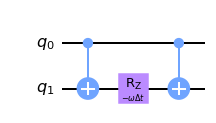

In [2]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.draw('mpl')

によって、計算基底$\ket{00}, \ket{01}, \ket{10}, \ket{11}$はそれぞれ

$$
\begin{align}
\ket{00} \rightarrow e^{i \omega \Delta t / 2} \ket{00} \\
\ket{01} \rightarrow e^{-i \omega \Delta t / 2} \ket{01} \\
\ket{10} \rightarrow e^{-i \omega \Delta t / 2} \ket{10} \\
\ket{11} \rightarrow e^{i \omega \Delta t / 2} \ket{11}
\end{align}
$$

と変換するので（確認してください）、まさに$\exp(\frac{i \omega \Delta t}{2} \sigma^Z_j\sigma^Z_{j+1})$の表現になっています。

残りの2つの演算子も同様にパリティに対する回転で表せますが、CNOTで表現できるのは$Z$方向のパリティだけなので、先にスピンを回転させる必要があります。$\exp(\frac{i \omega \Delta t}{2} \sigma^X_j\sigma^X_{j+1})$による変換は

$$
\begin{align}
\rightket_j \rightket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \rightket_j \rightket_{j+1} \\
\rightket_j \leftket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \rightket_j \leftket_{j+1} \\
\leftket_j \rightket_{j+1} \rightarrow e^{-i \omega \Delta t / 2} \leftket_j \rightket_{j+1} \\
\leftket_j \leftket_{j+1} \rightarrow e^{i \omega \Delta t / 2} \leftket_j \leftket_{j+1}
\end{align}
$$

で、式{eq}`left_right_kets`から、次の回路が対応する変換を引き起こすことがわかります（これも確認してください）。

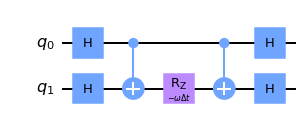

In [3]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.h(0)
circuit.h(1)
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.h(0)
circuit.h(1)
circuit.draw('mpl')

最後に、$\exp(\frac{i \omega \Delta t}{2} \sigma^Y_j\sigma^Y_{j+1})$に対応する回路は

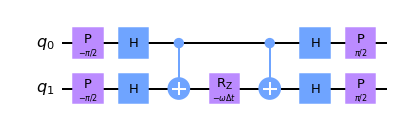

In [4]:
circuit = QuantumCircuit(QuantumRegister(2, 'q'))
circuit.p(-np.pi / 2., 0)
circuit.p(-np.pi / 2., 1)
circuit.h(0)
circuit.h(1)
circuit.cx(0, 1)
circuit.rz(Parameter(r'-$\omega \Delta t$'), 1)
circuit.cx(0, 1)
circuit.h(0)
circuit.h(1)
circuit.p(np.pi / 2., 0)
circuit.p(np.pi / 2., 1)
circuit.draw('mpl')

です[^sgate]。

### 回路実装

やっと準備が整ったので、シミュレーションを実装しましょう。実機で走らせられるように、$n=5$, $M=10$, $\omega \Delta t = 0.1$とします。上で決めたように、ビット0以外が$\upket$、ビット0が$\rightket$という初期状態から始めます。各$\Delta t$ステップごとに回路のコピーをとり、それぞれのコピーで測定を行うことで、時間発展の様子を観察します。

[^sgate]: $P(\pi/2)$ゲートは$S$ゲートとも呼ばれます。$P(-\pi/2)$は$S^{\dagger}$です。

In [5]:
n = 5
M = 10
omegadt = 0.1

circuits = []

circuit = QuantumCircuit(n)

# Bit 0 in state 1/sqrt(2)(|0> + |1>)
circuit.h(0)

for istep in range(M):
    for j in range(n - 1):
        # ZZ
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)

        # XX
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)

        # YY
        circuit.p(-np.pi / 2., j)
        circuit.p(-np.pi / 2., j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.cx(j, j + 1)
        circuit.rz(-omegadt, j + 1)
        circuit.cx(j, j + 1)
        circuit.h(j)
        circuit.h(j + 1)
        circuit.p(np.pi / 2., j)
        circuit.p(np.pi / 2., j + 1)

    # Save a copy of the circuit at this point
    # measure_all(inplace=False) creates a copy of the circuit with a full measurement at the end
    circuits.append(circuit.measure_all(inplace=False))
    
print('{} circuits created'.format(len(circuits)))

10 circuits created


量子回路シミュレーターで実行し、各ビットにおける$Z$方向スピンの期待値をプロットしましょう。あとで実機の結果に対しても同じプロットを作るので、先にそのための関数を定義します。

In [6]:
# Notebooks in mybinder.org starts in the root directory of the repository
import os
import sys
if 'source' in os.listdir('.'):
    sys.path.append('{}/source'.format(os.getcwd()))
    
from utils.heisenberg import get_exact_solutions

def plot_z_expectations(counts_list, n, omegadt, add_theory=False):
    M = len(counts_list)

    # [[0., 0., ...], [omegadt, omegadt, ...], ..., [M*omegadt, M*omegadt, ...]] x values for each spin
    x = np.tile(np.expand_dims(np.linspace(0., omegadt * M, M + 1, endpoint=True), 1), (1, n))
    y = np.zeros_like(x)

    # Initial state expectation values
    y[0, 0] = 0.
    y[0, 1:] = 1.

    for istep in range(M):
        counts = counts_list[istep]

        total = 0
        for bitstring, count in counts.items():
            # 1. reverse the bitstring (last bit is the least significant)
            # 2. map all bits to integers
            # 3. compute spin = (1 - 2*bit) <- bit = 0 corresponds to spin +1
            spinval = 1 - np.array(list(map(int, reversed(bitstring))), dtype=float) * 2
            y[istep + 1] += count * spinval
            total += count
        
        y[istep + 1] /= total

    fig, ax = plt.subplots(1, 1)

    if add_theory:
        initial_state = np.zeros(2 ** n, dtype=np.complex128)
        initial_state[0:2] = np.sqrt(0.5)
        
        exact_x, exact_y = get_exact_solutions(n, initial_state, omegadt * M)

        lines = ax.plot(exact_x, exact_y)

    # TODO use the same colors
    ax.plot(x, y, 'o')
    ax.legend(lines, ['bit%d' % i for i in range(n)])
    
print('Defined function plot_z_expectations')

Defined function plot_z_expectations


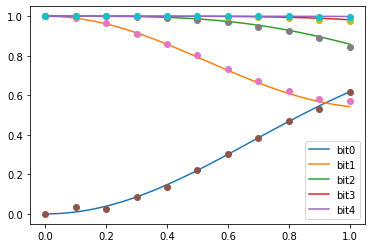

In [7]:
from qiskit import Aer, execute
import matplotlib.pyplot as plt

shots = 10000

qasm_simulator = Aer.get_backend('qasm_simulator')

sim_job = execute(circuits, qasm_simulator, shots=shots)
sim_counts_list = sim_job.result().get_counts()
   
plot_z_expectations(sim_counts_list, n, omegadt, add_theory=True)

ビット0でのスピンの不整合が徐々に他のビットに伝搬していく様子が観察できました。

実機でも同様の結果が得られるでしょうか。QV32の5量子ビットマシンで確認してみましょう。

In [8]:
from qiskit import IBMQ
from qiskit.tools.monitor import job_monitor
from qiskit.providers.ibmq import least_busy

IBMQ.enable_account('__paste_your_token_here__')
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')

backend_filter = lambda b: (not b.configuration().simulator) and b.configuration().n_qubits >= n and b.configuration().quantum_volume >= 32 and b.status().operational
backend = least_busy(provider.backends(filters=backend_filter))

job = execute(circuits, backend, shots=8192, optimization_level=3)

job_monitor(job, interval=2)

In [8]:
counts_list = job.result().get_counts()

plot_z_expectations(counts_list, n, omegadt)

### おまけ：測定エラーの緩和

{doc}`前半<extreme_simd>`でも触れましたが、実機での量子回路の実行にはエラーがつきものです。前回はCNOTのエラー率の高さに注目してCNOTを極力減らす回路を書きましたが、今回のシミュレーションではなかなかこれ以上CNOTを減らす工夫のしようがなさそうです。

そこで、今度は別のエラーソースに着目しましょう。実は量子回路では測定自体でもエラーが発生します。例えば、次の回路を実行しても、`'1'`という結果が一定の確率で得られます。

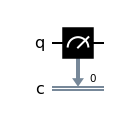

In [10]:
circuit = QuantumCircuit(QuantumRegister(1, 'q'), ClassicalRegister(1, 'c'))
circuit.measure(0, 0)
circuit.draw('mpl')

この回路にはゲートが一切ないので、本来ならば100%ビットの初期値である`'0'`が得られるはずです。このようなずれを測定エラーと呼びます。

測定エラーは統計的にだいたい再現性がある（あるビット列$x$が得られるべき状態から別のビット列$y$が得られる確率が、状態の生成法に依存しにくい）ので、事後的に緩和（部分的補正）できます。そのためには$n$ビットレジスタの$2^n$個すべての計算基底状態について、相当するビット列が100%の確率で得られるべき回路を作成し、それを測定した結果を利用します。

例えば$n=2$で状態$\ket{x} \, (x = 00, 01, 10, 11)$を測定してビット列$y$を得る確率が$\epsilon^x_y$だとします。このとき実際の量子計算をして測定で得られた確率分布が$\{p_y\}$であったとすると、その計算で本来得られるべき確率分布$\{P_x\}$は連立方程式

$$
p_{00} = P_{00} \epsilon^{00}_{00} + P_{01} \epsilon^{01}_{00} + P_{10} \epsilon^{10}_{00} + P_{11} \epsilon^{11}_{00} \\
p_{01} = P_{00} \epsilon^{00}_{01} + P_{01} \epsilon^{01}_{01} + P_{10} \epsilon^{10}_{01} + P_{11} \epsilon^{11}_{01} \\
p_{10} = P_{00} \epsilon^{00}_{10} + P_{01} \epsilon^{01}_{10} + P_{10} \epsilon^{10}_{10} + P_{11} \epsilon^{11}_{10} \\
p_{11} = P_{00} \epsilon^{00}_{11} + P_{01} \epsilon^{01}_{11} + P_{10} \epsilon^{10}_{11} + P_{11} \epsilon^{11}_{11}
$$

を解けば求まります。つまり、行列$\epsilon^x_y$の逆をベクトル$p_y$にかければいいわけです[^actually_fits]。

Qiskitでは測定エラー緩和用の関数やクラスが提供されているので、それを使って実際にエラーを求め、上のシミュレーションの結果の改善を試みましょう。

[^actually_fits]: 実際には数値的安定性などの理由から、単純に逆行列をかけるわけではなくフィッティングが行われますが、発想はここで書いたものと変わりません。

In [11]:
from qiskit.ignis.mitigation.measurement import complete_meas_cal, CompleteMeasFitter

# Define 32 calibration measurement circuits from a 5-qubit register
qreg = QuantumRegister(5)
meas_calibs, state_labels = complete_meas_cal(qr=qreg, circlabel='mcal')

# Run the circuits
calib_job = execute(meas_calibs, backend, shots=8192)

job_monitor(calib_job, interval=2)

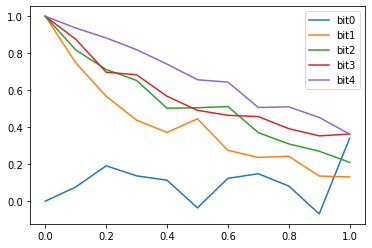

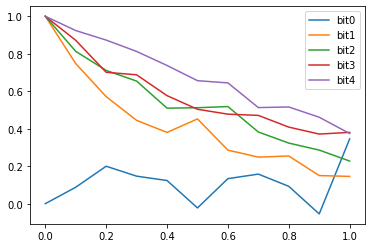

In [13]:
# Create an error corrector object
meas_fitter = CompleteMeasFitter(calib_job.result(), state_labels, circlabel='mcal')

# Get the filter object
meas_filter = meas_fitter.filter

# Results with mitigation
mitigated_counts_list = []
for counts in counts_list:
    mitigated_counts_list.append(meas_filter.apply(counts))

plot_z_expectations(mitigated_counts_list, n, omegadt)

違いはみられたでしょうか？（劇的な違いは期待できません。）